In [8]:
import json
from collections import defaultdict
import random
import math
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC, SVR
from sklearn.model_selection import (
    GridSearchCV, 
    RepeatedStratifiedKFold, 
    LeaveOneGroupOut,)
from xgboost import XGBClassifier, XGBRegressor  

In [17]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [18]:
y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

X_all = data.loc[:, y_3class.index.values].T  # untransformed data
X_cent = pd.DataFrame(StandardScaler(with_std=False).fit_transform(X_all), index=data_cols, columns=data.index)  # mean-centered only
X_zs = pd.DataFrame(StandardScaler().fit_transform(X_all), index=data_cols, columns=data.index)  # z-scored

# generate new rbg_cols and fbg_cols that retain the order from fg
rbg_cols = fg.loc[fg['bg_type'] == 'RBG'].index
fbg_cols = fg.loc[fg['bg_type'] == 'FBG'].index

In [ ]:
def random_fasted_split10(X, n_splits=10, n_repeats=5, random_state=1):
    """
    Only works for n_splits=10 on 30 total samples
    
    Because we are comparing only-random vs. only-fasted vs. all data, 
    only-random and only-fasted are at a disadvantage because they have 30 samples, 
    and 'all' has 60 samples, thus 'all' gets more training data.
    To compensate, at each split, pull random sample of 15 RBG and 15 FBG, 
    and get a list of (train, test) labels similar to the sklearn splitters.
    
    return list of (train_list, test_list) indexes
    """
    if n_splits != 10:
        raise ValueError('Must use n_splits=10')
    
    sample_indices = pd.Series(range(len(X)), index=X.index)
    rbg_cols = X.filter(regex='RBG', axis=0).index
    fbg_cols = X.filter(regex='FBG', axis=0).index
    custom_cv = []  # custom_cv splitter must return a list of (train, test) tuples
    for i in range(random_state, random_state + n_repeats):
        random.seed(i)
        samples = sample_indices.loc[random.sample(rbg_cols.to_list(), 15)].to_list() + \
                  sample_indices.loc[random.sample(fbg_cols.to_list(), 15)].to_list()
        for j in range(n_splits):
            start = 3 * j  # start and end are very brittle because of the 3 * j. Therefore only use n_splits=10
            end = 3 * j + 3
            test = samples[start:end]
            train = list(set(samples).difference(test))
            custom_cv.append((train, test))
    return custom_cv

def data_subset_hyperparam_search(
    model, 
    X, 
    y, 
    subsets,
    subset_names,
    param_grid, 
    scoring,
    CV,
    n_splits=10, 
    n_repeats=5, 
    n_jobs=-2, # -2 uses all but 1 core
    random_state=1,
    **gridsearchcv_kwargs
    ):
    """
    Performs hyperparameter grid search across data subsets (i.e. random-fed, fasted, both),
    
    Returns dataframe labeled with hyperparam grid search and prediction results 
    """
    results = defaultdict(dict)
    
    for subset, subset_name in zip(subsets, subset_names):
        cv = CV(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        # TODO: random_fasted_split10 has X argument 
            print(f'Using {subset_name}')
            gs = GridSearchCV(
                model, 
                param_grid,
                scoring=scoring,
                n_jobs=n_jobs,  
                cv=cv,
                # verbose=2,  # verbosity prints to the Anaconda Command prompt, so intercept it? 
                **gridsearchcv_kwargs,)
            gs.fit(X_all.loc[columns], y.loc[columns])
            results[column_name][y_name] = {}
            results[column_name][y_name]['cv_results'] = gs.cv_results_
            results[column_name][y_name]['gs_obj'] = gs
    
    results = dict(results)
    dfs = []
    for columns in column_names:
        for y_name in y_names:
            df = pd.DataFrame(results[columns][y_name]['cv_results'])
            df['data_subset'] = columns
            df['y_type'] = y_name
            dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True), results

### Steps:
1. `pipeline` of data for each model
    1. include mean-centering, z-scoring
    2. Alternatively, just use the X_all, X_mean_centered, X_zscore datasets appropriately
1. Hyperparam search all the models (be selective; only choose most important params)
2. Save best hyperparam for each model 
3. Perform CV to test score for each model (using best hyperparams)
    - From each CV iteration, derive feature importances for each model 
    - Average the feature importances in each CV iteration to gain a consensus importance 

### levels of searching:
1. Random vs. Fasted
1. Regression vs. Classification
    1. Regression: OGTT, weight, insulin, weekly BG
    2. Classification: 3-class or 2-class 
2. Models: 
    - Reg. and Clf: RF, SVM, mixed/fixed effects model, LinReg L1, LinReg Elastic Net, XGBoost, sparse PLS
    - Regression-only: LARS Regression 
    - Classification-only: Naive Bayes, logistic regression 
    - Reg vs. Clf require their own CVs 



In [11]:
LogisticRegressionCV().l1_ratios_ 

AttributeError: 'LogisticRegressionCV' object has no attribute 'l1_ratios_'

In [73]:
test = LogisticRegression(multi_class='multinomial',).fit(X_zs, y_3class)
test

LogisticRegression(multi_class='multinomial')

In [74]:
test.coef_

array([[-5.18287302e-03, -4.78519337e-03, -3.51791952e-03, ...,
        -1.39225132e-02, -1.33230310e-02, -2.46300580e-02],
       [-3.25525613e-03,  8.02934887e-03, -5.06165837e-05, ...,
        -2.24020292e-03,  1.87108969e-03,  1.12481404e-02],
       [ 8.43812915e-03, -3.24415550e-03,  3.56853610e-03, ...,
         1.61627161e-02,  1.14519413e-02,  1.33819176e-02]])

In [20]:
# Step 0. Logistic Regression has a CV method for quickly computing 
#         optimal regularization and L1/L2 ratio (C and l1_ratio)
rskf = RepeatedStratifiedKFold(n_splits=6, n_repeats=1, random_state=1)
lrcv = LogisticRegressionCV(
    Cs=10, 
    l1_ratios=[0.01, 0.1, 0.3, 0.5, 0.65, 0.8, 0.9, 0.95, 0.99],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    n_jobs=-2,
    random_state=1,
)
lrcv.fit(X_zs, y_3class)

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bjanderson23\anaconda3\lib\site-packages\

In [123]:
print(lrcv.C_, lrcv.l1_ratio_)

[0.35938137 0.35938137 0.35938137] [0.5 0.5 0.5]


<AxesSubplot:>

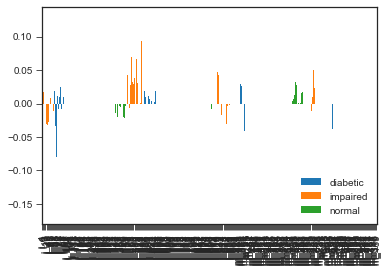

In [111]:
ldf = pd.DataFrame(lrcv.coef_, columns=lrcv.feature_names_in_, index=lrcv.classes_).T

# df[(df.values > 1.5).any(1)]
nzc = ldf.loc[(ldf != 0).any(axis=1)]  # nzc = non-zero coefficients 
nzc.plot.bar()

In [184]:
nzc.loc[nzc['normal'] != 0]

,diabetic,impaired,normal
l_43,0.000000,0.000000,0.017870
l_45,0.000000,0.008108,-0.063983
l_49,0.000000,-0.000654,0.017359
l_105,0.000000,-0.030961,0.001946
l_122,0.000896,-0.123113,0.003044
...,...,...,...
m_280,0.000000,-0.012240,0.046256
m_243,0.000000,0.000000,0.038053
m_693,0.011569,0.000000,-0.061117
m_391,-0.085347,0.000000,0.002312


In [179]:
filt = nzc.loc[(abs(nzc) > 0.015).any(axis=1)]
len(filt)
nzc_ids = data.loc[filt.loc[data['Proposed ID'] != 'unknown'].index, 'Proposed ID']
nzc_ids

l_211                       SM d40:7
l_230                        PC 38:7
l_238                        PC 34:4
l_239                       SM d36:3
l_262                   PC 18:2_20:4
l_304                   PC 18:1_22:6
l_312                        PC 37:5
l_323                       SM d36:2
l_371                   PC 18:0_20:5
l_377                       SM d35:1
l_410                   PC 18:0_22:6
l_479                       SM d36:0
l_492            Plasmanyl-PC O-32:1
l_499       Plasmanyl-PC O-16:0_16:0
l_519            Plasmanyl-PC O-40:5
l_521                      PE O-40:5
l_522                       SM d40:2
l_572       Plasmanyl-PC O-20:0_20:4
l_611                       SM d43:2
l_664                  Cer[NS] d41:1
l_721                       TG 62:13
l_752                       TG 60:11
l_947                        CE 18:1
m_45                       Ostruthin
m_82                   Decanoic acid
m_67     16-Hydroxyhexadecanoic acid
m_538                      NP-020871
m

In [187]:
filt.loc['m_409']

diabetic    0.000000
impaired   -0.025045
normal      0.024464
Name: m_409, dtype: float64

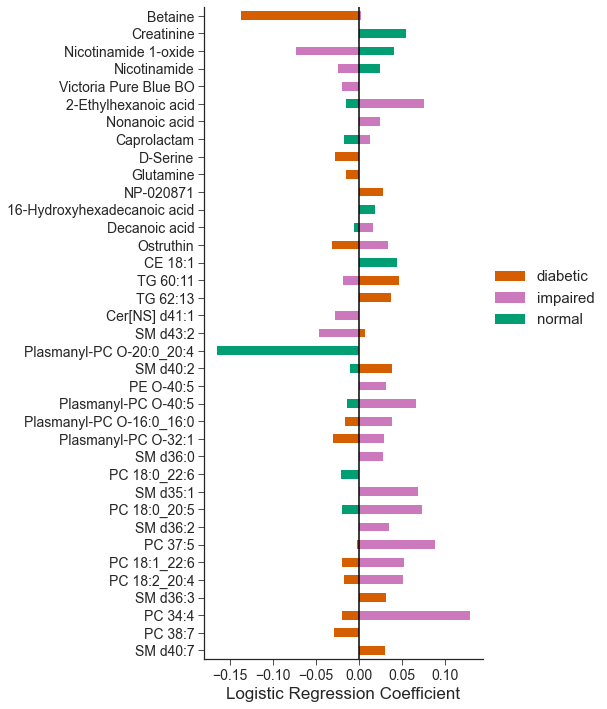

In [180]:
filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)
plt.gcf().set_size_inches(5, 12)
plt.yticks(plt.yticks()[0], nzc_ids, fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Logistic Regression Coefficient', fontsize=17)
plt.title('')
plt.axvline(color='black')
plt.legend(loc=(1.02, 0.5), fontsize=15, markerscale=2)
sns.despine()
plt.gcf().set_facecolor('white')

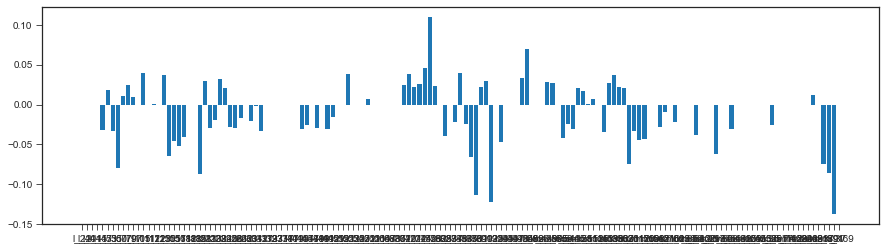

In [140]:
plt.bar(x=filt.index, height=filt['diabetic'])
plt.gcf().set_size_inches(15, 4)


array([0.5, 0.5, 0.5])

In [ ]:
# Step 1. define "pipelines" for each model (not true sklearn.pipelines)
clf_models = {
    'RF': [RandomForestClassifier, X_all],  # RepeatedStratifiedKFold
    'SVM': [SVC, X_zs],                     # RepeatedStratifiedKFold
    'LogR': [LogisticRegression, X_zs],     # RepeatedStratifiedKFold
    'XGB': [XGBClassifier, X_all],          # RepeatedStratifiedKFold
    # Naive Bayes coeficients aren't necessarily a good feature importance metric, 
    #     but it would be good to see NB's predictive performance.
    'NB': [GaussianNB, X_all],             # RepeatedStratifiedKFold
}
# reg_models = {}

In [ ]:
clf_hyperparams = {
    'RF': rfc_hyperparams,
    'SVM': svc_hyperparams,
    'LogR': 
} 

In [ ]:
LogisticRegression

In [ ]:
LogisticRegressionCV

In [5]:
data_subset_hyperparam_search

<function models.data_subset_hyperparam_search.data_subset_hyperparam_search(model, param_grid, scoring, X_all, columns_list, column_names, y_list, y_names, estimator_type, n_splits=10, n_repeats=5, n_jobs=-2, **kwargs)>